### Loading imports

In [23]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time
import requests
from bs4 import BeautifulSoup
import re
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import pprint

In [25]:
pp = pprint.PrettyPrinter(depth=6)

### Getting  Hymns and Hymnwriters of Denmark By J.C. AABERG

In [34]:
html = requests.get(url='http://www.gutenberg.org/cache/epub/29666/pg29666.txt')

#### Removing html formatting tags using BeautifulSoup module

In [35]:
cleantext = BeautifulSoup(html.text, "lxml").text

In [36]:
cleantext = re.sub('\n',' ',cleantext)
cleantext = re.sub('\r',' ',cleantext)
cleantext = re.sub('\ufeff',' ',cleantext)
cleantext = re.sub('[ ]{2,}','',cleantext)

In [37]:
vocab = sorted(set(cleantext))

In [38]:
print('Unique characters in the sentence :',len(vocab))
print(vocab)

Unique characters in the sentence : 86
[' ', '!', '"', '#', '$', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Ø', 'æ', 'ø']


#### Loading a spacy en small model for tokenization and stop word removal

In [39]:
nlp_model = spacy.load('en_core_web_sm')

In [40]:
spacy_document = nlp_model(cleantext)

In [41]:
print('Total No of tokens in the text :',len(spacy_document))

Total No of tokens in the text : 60072


In [42]:
words = pd.DataFrame([token.text for token in spacy_document if not token.is_stop and not token.is_punct],columns=['word'])

In [43]:
print('Unique words :',words['word'].nunique())

Unique words : 10503


In [44]:
ordered_frequency_words = words.groupby('word').agg('size').reset_index().rename(columns={0:'frequency_of_occurence'}).sort_values(by='frequency_of_occurence',
                                                                                                        ascending=False)

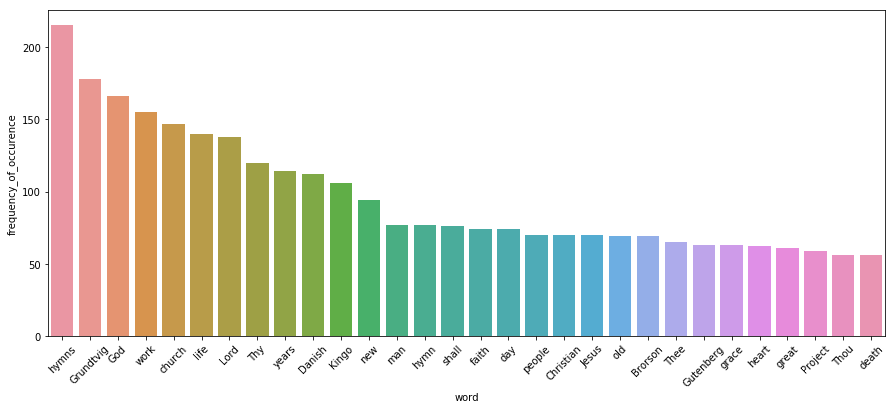

In [45]:
plt.figure(figsize=(15,6))
plot = sns.barplot(x=ordered_frequency_words['word'][:30],y=ordered_frequency_words['frequency_of_occurence'][:30])
plot.set_xticklabels(plot.get_xticklabels(),rotation=45)
plt.show(plot)

#### Indexing characters

In [56]:
index_dict = {character:index for character,index in zip(vocab,range(len(vocab)))}
values_dict = {index:character for character,index in zip(vocab,range(len(vocab)))}

In [47]:
pp.pprint(index_dict)

{' ': 0,
 '!': 1,
 '"': 2,
 '#': 3,
 '$': 4,
 '%': 5,
 "'": 6,
 '(': 7,
 ')': 8,
 '*': 9,
 ',': 10,
 '-': 11,
 '.': 12,
 '/': 13,
 '0': 14,
 '1': 15,
 '2': 16,
 '3': 17,
 '4': 18,
 '5': 19,
 '6': 20,
 '7': 21,
 '8': 22,
 '9': 23,
 ':': 24,
 ';': 25,
 '?': 26,
 '@': 27,
 'A': 28,
 'B': 29,
 'C': 30,
 'D': 31,
 'E': 32,
 'F': 33,
 'G': 34,
 'H': 35,
 'I': 36,
 'J': 37,
 'K': 38,
 'L': 39,
 'M': 40,
 'N': 41,
 'O': 42,
 'P': 43,
 'Q': 44,
 'R': 45,
 'S': 46,
 'T': 47,
 'U': 48,
 'V': 49,
 'W': 50,
 'X': 51,
 'Y': 52,
 'Z': 53,
 '[': 54,
 ']': 55,
 '_': 56,
 'a': 57,
 'b': 58,
 'c': 59,
 'd': 60,
 'e': 61,
 'f': 62,
 'g': 63,
 'h': 64,
 'i': 65,
 'j': 66,
 'k': 67,
 'l': 68,
 'm': 69,
 'n': 70,
 'o': 71,
 'p': 72,
 'q': 73,
 'r': 74,
 's': 75,
 't': 76,
 'u': 77,
 'v': 78,
 'w': 79,
 'x': 80,
 'y': 81,
 'z': 82,
 'Ø': 83,
 'æ': 84,
 'ø': 85}


In [48]:
cleantext_numerical = np.array([index_dict[character] for character in cleantext])

In [49]:
pp.pprint(cleantext[:13])
pp.pprint(cleantext_numerical[:13])

' The Project '
array([ 0, 47, 64, 61,  0, 43, 74, 71, 66, 61, 59, 76,  0])


In [51]:
data = tf.data.Dataset.from_tensor_slices(cleantext_numerical)

In [59]:
for i in data.take(5):
      pp.pprint(values_dict[i.numpy()])

' '
'T'
'h'
'e'
' '


In [60]:
input_seq_length = 100
examples_per_epoch = len(cleantext)//input_seq_length

In [62]:
character_sequences = data.batch(input_seq_length+1,drop_remainder=True)

In [63]:
def get_input_output(sequence):
    input_sequence = sequence[:-1]
    output_sequence = sequence[1:]
    return (input_sequence,output_sequence)

train_data = character_sequences.map(get_input_output)

In [67]:
for inputelement,outputelement in train_data.take(10):
    input_seq = ''
    output_seq = ''
    for e in inputelement.numpy():
        input_seq += values_dict[e]
    for e in outputelement.numpy():
        output_seq += values_dict[e]
    print('Input sequence')
    print(input_seq)
    print('Output sequence')
    print(output_seq)

Input sequence
 The Project Gutenberg EBook of Hymns and Hymnwriters of Denmark, byJens Christian AabergThis eBook 
Output sequence
The Project Gutenberg EBook of Hymns and Hymnwriters of Denmark, byJens Christian AabergThis eBook i
Input sequence
s for the use of anyone anywhere at no cost and withalmost no restrictions whatsoever.You may copy i
Output sequence
 for the use of anyone anywhere at no cost and withalmost no restrictions whatsoever.You may copy it
Input sequence
, give it away orre-use it under the terms of the Project Gutenberg License includedwith this eBook 
Output sequence
 give it away orre-use it under the terms of the Project Gutenberg License includedwith this eBook o
Input sequence
r online at www.gutenberg.netTitle: Hymns and Hymnwriters of DenmarkAuthor: Jens Christian AabergRel
Output sequence
 online at www.gutenberg.netTitle: Hymns and Hymnwriters of DenmarkAuthor: Jens Christian AabergRele
Input sequence
ase Date: August 11, 2009 [EBook #29666]Language: Eng

In [68]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [71]:
vocab_size = len(vocab) #No of unique characters
embedding_dim = 256 #Embedding vector size
rnn_units = 1024 # No of rnn units
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim,batch_input_shape=[BATCH_SIZE, None]))
model.add(tf.keras.layers.LSTM(rnn_units,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(vocab_size))

# sparse categorical crossentropy loss function 
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           22016     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 86)            88150     
Total params: 5,357,142
Trainable params: 5,357,142
Non-trainable params: 0
_________________________________________________________________


In [75]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=2, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

In [76]:
model.fit(train_data, epochs=20, callbacks=[callbacks])

Epoch 1/20
50/50 [==============================] - 502s 10s/step - loss: 2.4896
Epoch 2/20
50/50 [==============================] - 503s 10s/step - loss: 2.3272
Epoch 3/20
50/50 [==============================] - 448s 9s/step - loss: 2.1798
Epoch 4/20
50/50 [==============================] - 501s 10s/step - loss: 2.0481
Epoch 5/20
50/50 [==============================] - 505s 10s/step - loss: 1.9307
Epoch 6/20
50/50 [==============================] - 507s 10s/step - loss: 1.8282
Epoch 7/20
50/50 [==============================] - 585s 12s/step - loss: 1.7402
Epoch 8/20
50/50 [==============================] - 485s 10s/step - loss: 1.6648
Epoch 9/20
50/50 [==============================] - 430s 9s/step - loss: 1.5950
Epoch 10/20
50/50 [==============================] - 431s 9s/step - loss: 1.5334
Epoch 11/20
50/50 [==============================] - 477s 10s/step - loss: 1.4785
Epoch 12/20
50/50 [==============================] - 416s 8s/step - loss: 1.4288
Epoch 13/20
50/50 [==========

In [77]:
model.save('/home/giridhar/Downloads/generation_lstm.h5')

In [83]:
model.save_weights('/home/giridhar/Downloads/generation_lstms_weights.h5')

In [85]:
model.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "Embedding", "config": {"name": "embedding", "trainable": true, "batch_input_shape": [64, null], "dtype": "float32", "input_dim": 86, "output_dim": 256, "embeddings_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "embeddings_regularizer": null, "activity_regularizer": null, "embeddings_constraint": null, "mask_zero": false, "input_length": null}}, {"class_name": "LSTM", "config": {"name": "lstm", "trainable": true, "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": true, "unroll": false, "time_major": false, "units": 1024, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "recurrent_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_nam

In [81]:
from tensorflow.keras.models import load_model

In [92]:
saved_vocab_size = len(vocab) #No of unique characters
saved_embedding_dim = 256 #Embedding vector size
saved_rnn_units = 1024 # No of rnn units
saved_model = tf.keras.Sequential()
saved_model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim,batch_input_shape=[1, None]))
saved_model.add(tf.keras.layers.LSTM(rnn_units,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'))
saved_model.add(tf.keras.layers.Dense(vocab_size))\

In [93]:
saved_model.load_weights('/home/giridhar/Downloads/generation_lstms_weights.h5')

In [94]:
saved_model.build(tf.TensorShape([1, None]))

In [95]:
saved_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            22016     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 86)             88150     
Total params: 5,357,142
Trainable params: 5,357,142
Non-trainable params: 0
_________________________________________________________________


In [104]:
start_string = 'All hail to you'
num_characters_to_generate = 1000
input_eval = [index_dict[s] for s in start_string]
input_eval = tf.expand_dims(input_eval, 0)
temperature = 0.8
predicted_text = start_string
saved_model.reset_states()
for i in range(num_characters_to_generate):
    predictions = saved_model(input_eval)
    predictions = tf.squeeze(predictions, 0)
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    input_eval = tf.expand_dims([predicted_id], 0)
    predicted_text += values_dict[predicted_id]
    
print(predicted_text)


All hail to you commayThe hoarts, pe acidian, "Spiritual Sonsom is us first in these that he said, "-joy he had fear that the pastoral, bewas not only a new questions of positions which in his highty in the collection of a family of their own."The every family was, homento of His name and study even the suchaments contributions to the day is by a format challation.Whan, when by paradised may not leading our Lord and lovely,shearthf theirtued nour, and the book_, but he hashe spirit, but itof their isand made but one of the same like a man ofthe part of his state of the faith of a large them to his hisbability. Asthe material seems toward have.It is only through these disportances rightWe we shate hishand faith is here. Here and bring at all in the enested in thespirit of these assemblies in this earlier Danish poetly a compulsion. The resemble his state of a lows of prout himself best their work herespecially statements of his life. For hath beloved of atorn by another in their take wa